<a href="https://colab.research.google.com/github/hirani22/SoftwareEngg/blob/main/EquationSolver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**HANDWRITTEN EQUATION SOLVER USING CNN**

Importing Reqd Libraries and tools

In [52]:
import numpy as np 
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
#converts the numpy values to binary
import seaborn as sns

In [53]:
np.random.seed(2)

Uploading and Extracting Dataset using Google Drive.
Dataset has been downloaded from MNIST dataset and consists of approximately 85k images for raw dataset. Each image is 28x28 pixels. They have been encoded as 10 (/), 11(+),12(-), 13(*)

In [54]:
from google.colab import drive
#drive.mount('/content/drive')

In [55]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [56]:
dataset=pd.read_csv('/content/drive/MyDrive/Netra Hirani/EquationSolver_dataset.csv')

In [57]:
#creating label
y = dataset["label"]

In [58]:
#dropping label
X = dataset.drop(labels = ["label"], axis = 1)

In [59]:
#deleting dataset to reduce memory usage
del dataset

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


11    22164
12    21387
1      4684
7      4401
3      4351
9      4188
2      4177
6      4137
0      4132
4      4072
8      4063
5      3795
13       80
10       78
Name: label, dtype: int64

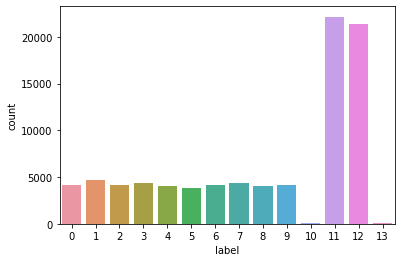

In [60]:
#visualizing the dataset
g = sns.countplot(y)
y.value_counts()

In [61]:
#Grayscale normalization to reduce the effect of illumination differences.
#Grayscale normalization is used to bring all the images with intensity values into a specific range 
X = X / 255.0

In [62]:
#reshaping the dataset [size, height, width, channels = 1 due to grayscale].
X = X.values.reshape(-1,28,28,1)

In [63]:
#categorical conversion of label
y = to_categorical(y, num_classes = 14)

In [64]:
#90% Training and 10% Validation split
random_seed = 2
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.1 , random_state = random_seed, stratify = y)

Building CNN model

In [65]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
#Conv2D filters extend through the three channels in an image (Red, Green, and Blue). 
#The filters may be different for each channel too.
#Max pooling selects the brighter pixels from the image.
from tensorflow.keras.optimizers import RMSprop #rootmeansquare
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau #reduce learning rate
#This callback monitors a quantity and if no improvement is seen for a 'patience' number of epochs, 
#the learning rate is reduced.
from tensorflow import keras

In [66]:
#creating the instance of the model
model = Sequential()

In [67]:
#adding layers to the model
#Layer: 1
#Mandatory Conv2D parameter is the numbers of filters that convolutional layers will learn from.
model.add(Conv2D(filters = 32, kernel_size = (5,5), padding = "Same", activation = "relu", input_shape = (28, 28, 1)))
#we are learning from 32 filters, kernel size is specifying the height and width of the convolution window
#activation is simply here for convenience stating which activation will be performed after convolution 
model.add(Conv2D(filters = 32, kernel_size = (5,5), padding = "Same", activation = "relu"))
model.add(MaxPool2D(pool_size = (2,2)))
#maxpool is here to reduce the spatial dimensions of the output
model.add(Dropout(0.25))
#dropout for regularization. i.e. prevent overfitting

In [ ]:
#Layer: 2
model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = "Same", activation = "relu"))
model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = "Same", activation = "relu"))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout(0.25))

In [68]:
#fully connected layer and output
model.add(Flatten())
#flattens multi-dimensional output to single dimension
model.add(Dense(256, activation = "relu"))
#fully connected layer. Sort of adds a hidden layer and neuron by neuron collectively passes to the o/p layer
model.add(Dropout(0.25))
model.add(Dense(14, activation = "softmax"))

In [69]:
#Set the optimizer
optimizer = RMSprop(lr = 0.001, rho = 0.9, epsilon = 1e-08, decay=0.0 )

model.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics = ["accuracy"])

learning_rate_reduction = ReduceLROnPlateau(monitor = "val_accuracy",
                                            patience = 3,
                                            verbose = 1,
                                            factor = 0.5,
                                            min_lr = 0.0001)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
#data augmentation
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

In [ ]:
datagen.fit(X_train)
#fitting the model
epochs = 5
batch_size = 86

history = model.fit_generator(
                                datagen.flow(X_train,y_train, batch_size=batch_size),
                                epochs = epochs, #An epoch is an iteration over the entire x and y data provided
                                validation_data = (X_val,y_val), #Data on which to evaluate the loss and any model metrics at the end of each epoch. 
                                verbose = 2, #output
                                steps_per_epoch=X_train.shape[0] // batch_size,  # Total number of steps (batches of samples) before declaring one epoch finished and starting the next epoch.
                                callbacks=[learning_rate_reduction]                            
                              )

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
896/896 - 505s - loss: 0.2911 - accuracy: 0.9098 - val_loss: 0.0491 - val_accuracy: 0.9870
Epoch 2/5
896/896 - 505s - loss: 0.0805 - accuracy: 0.9760 - val_loss: 0.0323 - val_accuracy: 0.9905
Epoch 3/5
896/896 - 505s - loss: 0.0634 - accuracy: 0.9817 - val_loss: 0.0386 - val_accuracy: 0.9887
Epoch 4/5
896/896 - 504s - loss: 0.0567 - accuracy: 0.9835 - val_loss: 0.0331 - val_accuracy: 0.9915
Epoch 5/5
896/896 - 502s - loss: 0.0560 - accuracy: 0.9845 - val_loss: 0.0340 - val_accuracy: 0.9914


We need to save the model before we continue to later deploy and apply. We plan to do so using a .h5 extension since HDF5 uses a "file directory" like structure that allows you to organize data within the file in many different structured ways.

In [34]:
from PIL import Image
#PIL is Python Imaging Library
from itertools import groupby
#itertools are fast, memory-efficient tools
#groupby- This method calculates the keys for each element present in iterable. 

In [35]:
image = Image.open("/content/drive/MyDrive/Netra Hirani/testing.png").convert("L")

In [37]:
#resizing to 28 height pixels
w = image.size[0]
h = image.size[1]
r = w / h # aspect ratio
new_w = int(r * 28)
new_h = 28
new_image = image.resize((new_w, new_h))

In [38]:
#converting to a numpy array
new_image_arr = np.array(new_image)

In [39]:
#inverting the image to make background = 0
new_inv_image_arr = 255 - new_image_arr

In [40]:
#rescaling the image
final_image_arr = new_inv_image_arr / 255.0

Further OCR and parsing of the image needs to be done. We need to resize then and then finally predict the uploaded equation before sending it to the multidigit calculator. 

In [50]:
#mathematical operations
def math_expression_generator(arr):
    
    op = {
              10,   # = "/"
              11,   # = "+"
              12,   # = "-"
              13    # = "*"
                  }   
    
    m_exp = []
    temp = []
        
    #creating a list separating all elements
    for item in arr:
        if item not in op:
            temp.append(item)
        else:
            m_exp.append(temp)
            m_exp.append(item)
            temp = []
    if temp:
        m_exp.append(temp)
        
    #converting the elements to numbers and operators
    i = 0
    num = 0
    for item in m_exp:
        if type(item) == list:
            if not item:
                m_exp[i] = ""
                i = i + 1
            else:
                num_len = len(item)
                for digit in item:
                    num_len = num_len - 1
                    num = num + ((10 ** num_len) * digit)
                m_exp[i] = str(num)
                num = 0
                i = i + 1
        else:
            m_exp[i] = str(item)
            m_exp[i] = m_exp[i].replace("10","/")
            m_exp[i] = m_exp[i].replace("11","+")
            m_exp[i] = m_exp[i].replace("12","-")
            m_exp[i] = m_exp[i].replace("13","*")
            
            i = i + 1
    
    #joining the list of strings to create the mathematical expression
    separator = ' '
    m_exp_str = separator.join(m_exp)
    
    return (m_exp_str)

#creating the mathematical expression
    m_exp_str = math_expression_generator(elements_pred)

    'calculating the mathematical expression using eval()'
    while True:
      try:
        answer = eval(m_exp_str)    #evaluating the answer
        answer = round(answer, 2)
        equation  = m_exp_str + " = " + str(answer)
        print(equation)   #printing the equation
        break

      except SyntaxError:
        print("Invalid predicted expression!!")
        print("Following is the predicted expression:")
        print(m_exp_str)
        break